Observationally, dense cores are often found in strands of high density gas with magnetic field through them. In the ``MHDSphere`` example, we try to model this by initializing a magnetic field in the z direction through our rotating, collapsing sphere.

![test](https://github.com/dorisjlee/remote/blob/master/astroSim-tutorial-img/hourglass.png?raw=True)

Hourglass-shaped magnetic field in dense core NGC 1333 IRAS 4A ([Girart et al., 2006](https://www.cfa.harvard.edu/sma/research/imageGallery/sciPages/JGirart/))

The strength of the magnetic field is often characterized by the variable $\beta$ (so-called `plasma beta'). Since we have already used $\beta$ for the rotation parameter, let's use $\alpha$ instead. 

The magnetic field exerts a pressure on the gas with magnitude (cgs)
$$ P_{B} = B^2/8\pi, $$
where $B$ is the magnitude of the magnetic field $B=|\vec{B}|$. The ratio of the thermal pressure to the magnetic pressure is the plasma `$\alpha$':
$$ \alpha = \frac{P_T}{P_B} = \frac{\rho c^2}{B^2/8\pi}\ .$$
where $P_T$ is the thermal pressure.
 So it is easily shown that the magnetic field is determined by the single parameter $\alpha$,
$$B=\sqrt{\frac{8\pi P_T}{\alpha}}$$
Small values of $\alpha$ imply strong magnetic fields. Observations of clouds typically reveal $\alpha$ values $\leq 1$, implying that the magnetic field can play a dynamic role in the star formation process. 

In setting up the initial magnetic field, you can use the equation above to solve for $B$ as a function of $\alpha$, $\rho$, and $c_s$. For simple initial conditions, try setting up a uniform magnetic field in the $z$-direction. In that case $B_z=B$. 

We first try doing the simulation without rotation ($\beta=0$) with a strong magnetic field ($\alpha \sim 0.1$).



#### Adding alpha as a new parameter 

Inside Simulation_init(): 
~~~fortran
call RuntimeParameters_get('alpha',alpha) ! thermal-to-magnetic pressure ratio
~~~
Inside Simulation_data: 
~~~fortran
real, save :: sim_rhoLeft, sim_rhoRight, sim_pLeft, sim_pRight, fattening_factor,beta_param,alpha
~~~

Inside Config declare new variable: 
    
    PARAMETER alpha REAL 1.

# Initializing magnetic fields in Simulation_initBlock.F90

~~~fortran
use Simulation_data, ONLY: sim_smallX, sim_gamma, sim_smallP,fattening_factor,beta_param,alpha
~~~

In [10]:
8*pi

25.132741228718345

~~~fortran
   ! MHD
   Bz = sqrt(25.132*presZone/alpha)
   call Grid_putPointData(blockId, CENTER, MAGX_VAR, EXTERIOR, axis, 0.0)
   call Grid_putPointData(blockId, CENTER, MAGY_VAR, EXTERIOR, axis, 0.0)
   call Grid_putPointData(blockId, CENTER, MAGZ_VAR, EXTERIOR, axis, Bz)
~~~

# Setting up MHD in FLASH 

There are two types of MHD solvers in FLASH: the 8 wave solver and the unsplit staggered mesh solver. Our experience caused magnetic fields to become very small during the simulation and the 8 wave solver seems to resolve that issue. 

Inside Config load in the 8 wave solver:
~~~fortran
REQUESTS physics/Hydro/HydroMain/split/MHD_8Wave
~~~

To use these solvers include the flag +8wave in ./setup: 

    ./setup MHDRotatingSinkSphere -3d +8wave --maxblock=500 -auto ; cd object/;make -j8;

# Analyzing MHD data with yt

During MHD runs, FLASH stores 3 extra variable for $B_{x,y,z}$. We can look at the derived field to see some additional interesting fields: 

In [1]:
%pylab inline 
from scripts.plotSim import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ~/proj/dlee/FLASH4.3/object/

/global/project/projectdirs/astro250/dlee/FLASH4.3/object



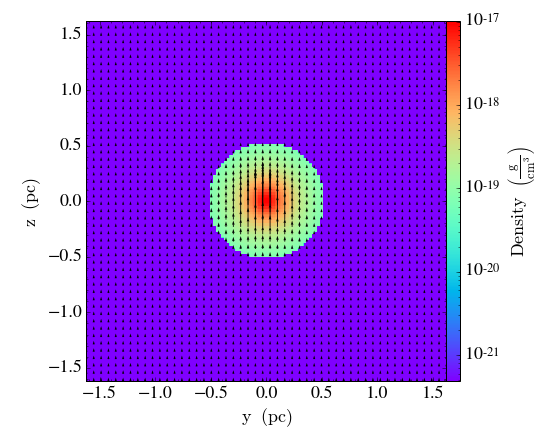

In [5]:
plot_var(0,cut="x",physical_quantity="density",magnetic=True)


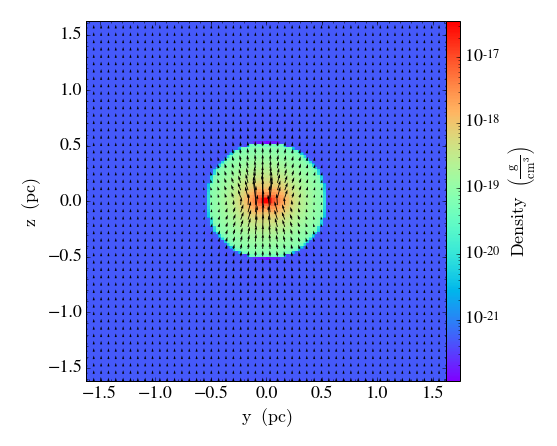

In [11]:
plot_var(70,cut="x",physical_quantity="density",magnetic=True)


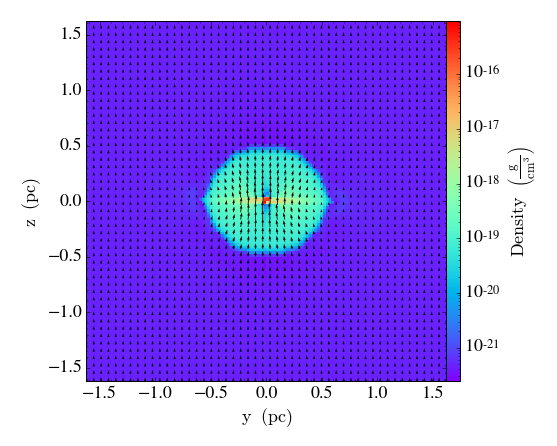

In [12]:
plot_var(190,cut="x",physical_quantity="density",magnetic=True)


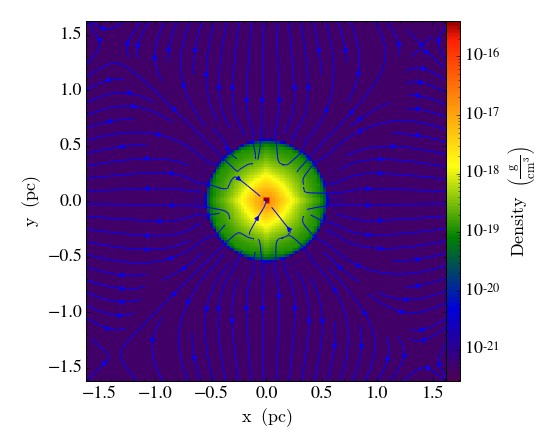

In [15]:
import yt
fname="sphere"
i=150
ds = yt.load("{0}_hdf5_chk_{1}".format(fname,str(i).zfill(4)))
physical_quantity="density"
slc = yt.SlicePlot(ds,"z",physical_quantity)#,center=(0.5,0.5,0.5))
slc.set_figure_size(5)
slc.annotate_streamlines('velocity_x', 'velocity_y')


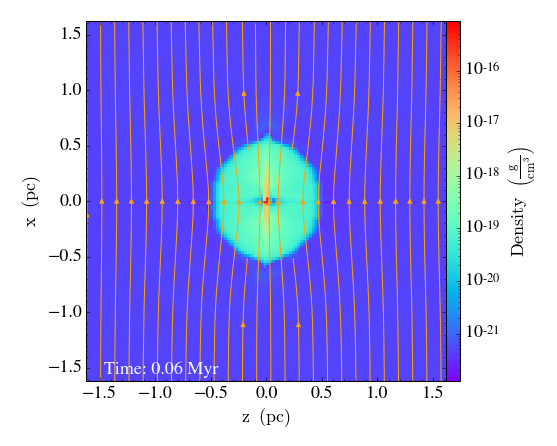

In [43]:
fname="sphere"
i=190
ds = yt.load("{0}_hdf5_chk_{1}".format(fname,str(i).zfill(4)))
physical_quantity="density"
cut ="y"
magnetic=True
slc = yt.SlicePlot(ds,cut,physical_quantity)#,center=(0.5,0.5,0.5))
slc.set_figure_size(5)
slc.set_cmap("all","rainbow")
if magnetic and cut == "x": slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z',factor=100,plot_args={'color':'orange'})
if magnetic and cut == "y": slc.annotate_streamlines('magnetic_field_x', 'magnetic_field_z',factor=100,plot_args={'color':'orange'})
slc.annotate_text((0.05, 0.02),"Time: {} Myr".format(round(ds.current_time.in_cgs().in_units('Myr'),3)), coord_system='axis')


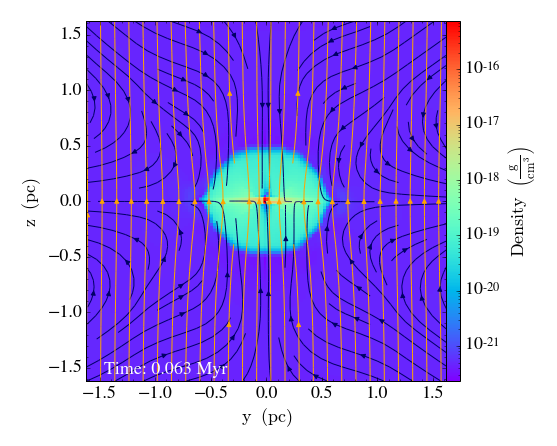

In [53]:
fname="sphere"
i=198
ds = yt.load("{0}_hdf5_chk_{1}".format(fname,str(i).zfill(4)))
physical_quantity="density"
cut ="x"
magnetic=True
slc = yt.SlicePlot(ds,cut,physical_quantity)#,center=(0.5,0.5,0.5))
slc.set_figure_size(5)
slc.set_cmap("all","rainbow")
velocity=True
if cut == "x": 
    if velocity:slc.annotate_streamlines('velocity_y', 'velocity_z',factor=100,plot_args={'color':'#000066'})    
    if magnetic:slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z',factor=100,plot_args={'color':'orange'})
if cut == "y": 
    if velocity:slc.annotate_streamlines('velocity_x', 'velocity_z',factor=100,plot_args={'color':'#000066'})    
    if magnetic:slc.annotate_streamlines('magnetic_field_x', 'magnetic_field_z',factor=100,plot_args={'color':'orange'})
if cut == "z": 
    if velocity:slc.annotate_streamlines('velocity_x', 'velocity_y',factor=100,plot_args={'color':'#000066'})    
    if magnetic:slc.annotate_streamlines('magnetic_field_x', 'magnetic_field_y',factor=100,plot_args={'color':'orange'})

slc.annotate_text((0.05, 0.02),"Time: {} Myr".format(round(ds.current_time.in_cgs().in_units('Myr'),3)), coord_system='axis')

Note that FLASH solves the MHD equations in non-dimensional scheme, which means that $B_{\rm simulation} = \frac{B_{\rm actual}}{\sqrt{4\pi}}$. By default, yt assumes cgs and does not recognize this factor of $\sqrt{4\pi}$ when computing the magnetic pressure and strengths, so we need to include this factor. We can check that $\alpha$ correspond to our input parameter : 
